In [99]:
import pandas as pd
import numpy as np
np.random.seed(1907)

#For classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#For visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


#To remove stopwords
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
#Remove stopwords for easier parsing afterwards
stop_words = list(stopwords.words("english"))

df = pd.read_csv("../../data/abstract_dataset.csv",header=None)
df.columns = ["title","DOI","Abstract","Task"]
df.head(5)

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,DOI,Abstract,Task
0,nnU-Net: a self-configuring method for deep le...,10.1038/s41592-020-01008-z,biomedical imaging is a driver of scientific d...,Cardiac
1,Automated cardiovascular magnetic resonance im...,10.1186/s12968-018-0471-x,cardiovascular resonance cmr imaging is a stan...,Cardiac
2,Deep Learning for Cardiac Image Segmentation: ...,10.3389/fcvm.2020.00025,deep learning has become the most widely used ...,Cardiac
3,Deep Learning for Segmentation Using an Open L...,10.1109/tmi.2019.2900516,delineation of the cardiac structures from 2d ...,Cardiac
4,Multi-Scale Self-Guided Attention for Medical ...,10.1109/jbhi.2020.2986926,even though convolutional neural networks cnns...,Cardiac


## Data Analysis

### Task representation

<AxesSubplot: xlabel='count', ylabel='Task'>

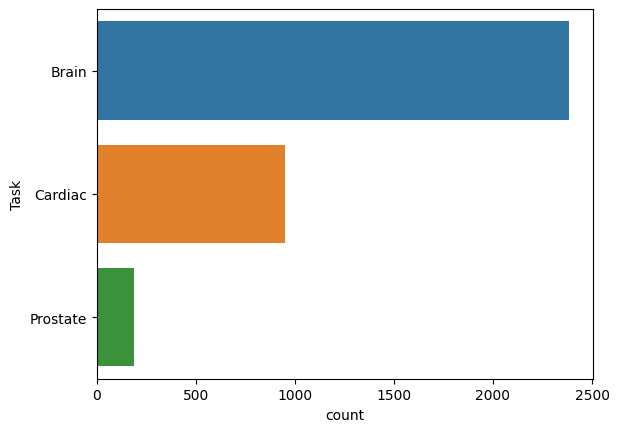

In [100]:
sns.countplot(data=df,y='Task',order=df["Task"].value_counts().index)

Note: imbalanced class distribution , not a lot of exemples for Prostate class

### Wordcloud per task without tf-idf

Plot of most frequent word in paper abstracts for each task

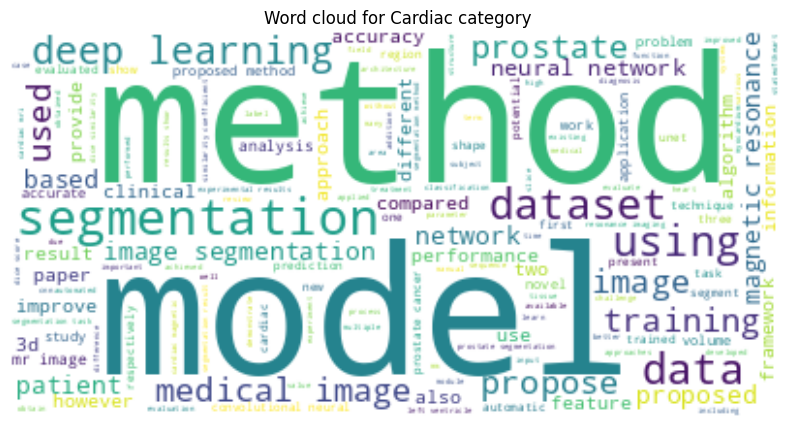

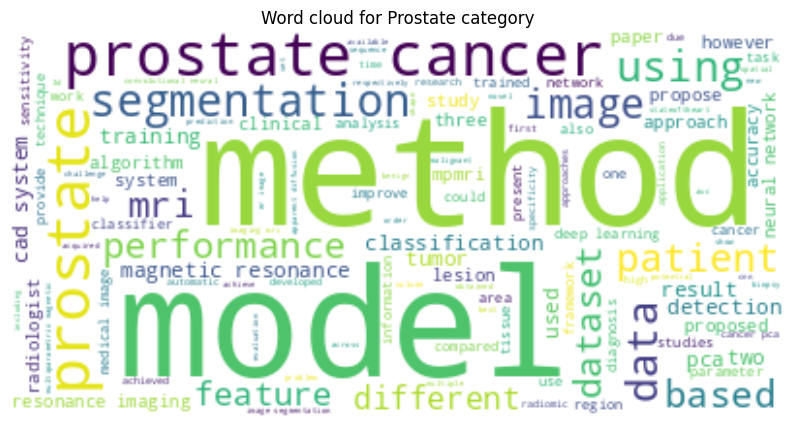

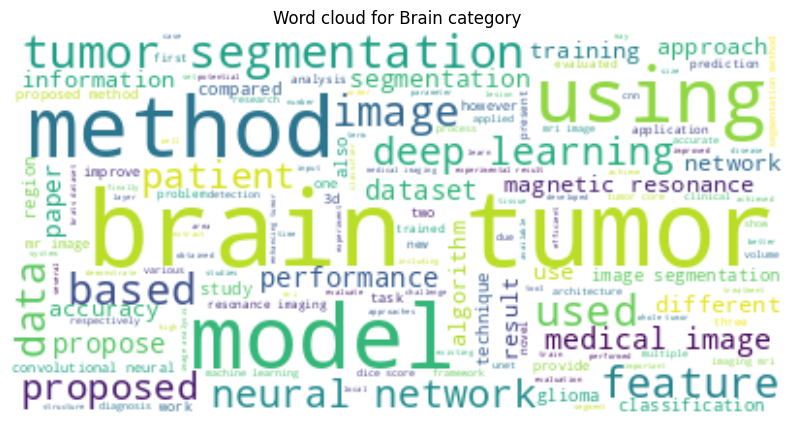

In [3]:
for task in df["Task"].unique():
    #Get text of the category
    task_df = df[df["Task"]==task]
    text = ' '.join(task_df["Abstract"])

    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(text)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Wordcloud per task with tf-idf

Plot of most frequent word in paper abstracts for each task using tf-idf over the whole dataset (not 1 tf-idf per task)

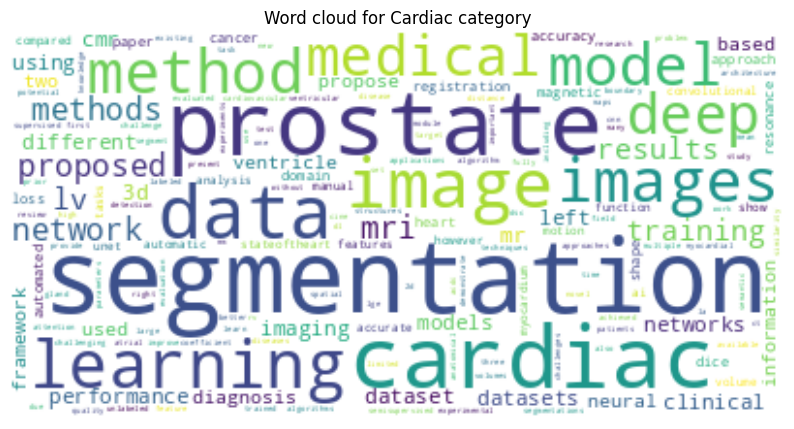

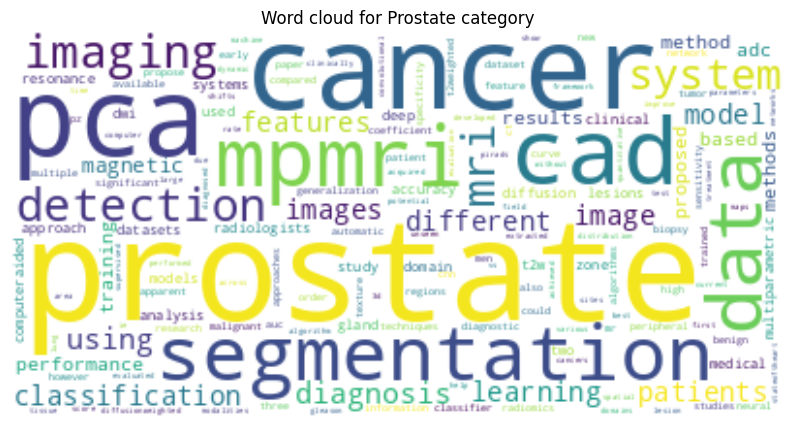

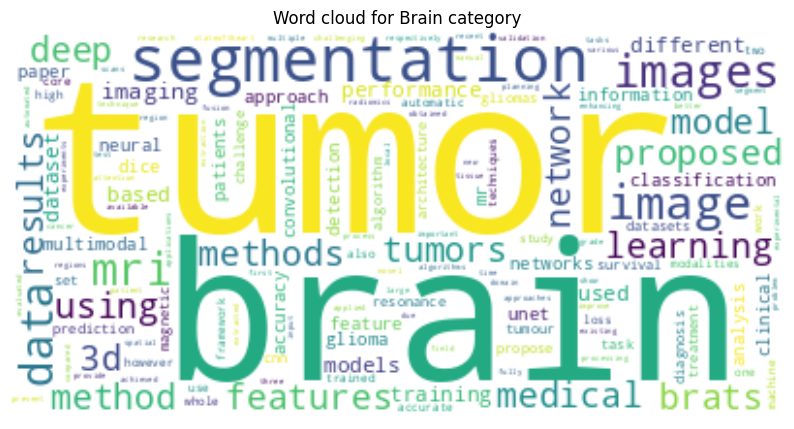

In [4]:
corpus = df["Abstract"].to_list()
vectorizer = TfidfVectorizer(stop_words=stop_words)
vecs = vectorizer.fit(corpus)
feature_names = vectorizer.get_feature_names_out()

for task in df["Task"].unique():
    #Get text of the category
    task_df = df[df["Task"]==task]
    corpus = task_df["Abstract"].to_list()
    vecs = vectorizer.transform(corpus)
    dense = vecs.todense()
    lst1 = dense.tolist()
    df_tf_idf = pd.DataFrame(lst1, columns=feature_names)

    x = df_tf_idf.T.sum(axis=1)
    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate_from_frequencies(x)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

Notes: presence of word "prostate" when using tf-idf with cardiac task papers may lead to problem

## Multi-class Classification with TF-IDF representation and keeping paper with multiple dataset

In [101]:
np.random.seed(1907)

train,test = train_test_split(df,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["Abstract"].to_list()
X_dev = dev["Abstract"].to_list()
X_test = test["Abstract"].to_list()

y_train = train["Task"].to_list()
y_dev = dev["Task"].to_list()
y_test = test["Task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

### List of words selected with TF-IDF

In [77]:
print(vectorizer.get_feature_names_out())

['3d' 'accuracy' 'accurate' 'achieved' 'algorithm' 'algorithms' 'also'
 'analysis' 'approach' 'approaches' 'architecture' 'attention' 'automated'
 'automatic' 'available' 'based' 'better' 'brain' 'brats' 'cancer'
 'cardiac' 'challenge' 'classification' 'clinical' 'cnn' 'compared'
 'convolutional' 'data' 'dataset' 'datasets' 'deep' 'detection'
 'diagnosis' 'dice' 'different' 'due' 'evaluated' 'feature' 'features'
 'first' 'framework' 'glioma' 'high' 'however' 'image' 'images' 'imaging'
 'improve' 'information' 'learning' 'loss' 'magnetic' 'manual' 'medical'
 'method' 'methods' 'model' 'models' 'mr' 'mri' 'multimodal' 'multiple'
 'network' 'networks' 'neural' 'new' 'novel' 'one' 'paper' 'patients'
 'performance' 'prediction' 'propose' 'proposed' 'prostate' 'research'
 'resonance' 'respectively' 'results' 'segmentation' 'set' 'show'
 'stateoftheart' 'study' 'task' 'tasks' 'techniques' 'three' 'time'
 'trained' 'training' 'treatment' 'tumor' 'tumors' 'two' 'unet' 'use'
 'used' 'using' 'wor

### Error Analysis

Train accuracy: 0.8470254957507082


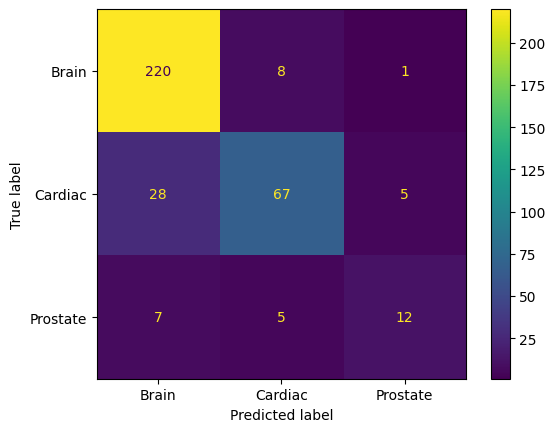

In [102]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

Note: Poor results on Prostate class but good ones on Brain and Cardiac. Multiple possible reasons for the prostate class results, not enough exemples for Prostate class or maybe papers that reference Prostate dataset often reference other task dataset.

### Removing papers with multiple datasets

In [105]:
np.random.seed(1907)

df_unique = df.drop_duplicates(subset=['title','DOI'],keep=False)

train,test = train_test_split(df_unique,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["Abstract"].to_list()
X_dev = dev["Abstract"].to_list()
X_test = test["Abstract"].to_list()

y_train = train["Task"].to_list()
y_dev = dev["Task"].to_list()
y_test = test["Task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

Train accuracy: 0.9134328358208955


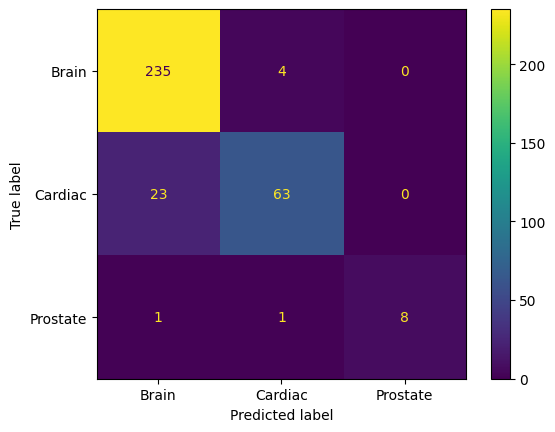

In [106]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

In [112]:
err_df = dev.copy()[y_pred!=y_dev]
err_df["pred"] = y_pred[y_pred!=y_dev]
err_df[dev["Task"] == "Cardiac"]

/tmp/ipykernel_4320/2064843489.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err_df[dev["Task"] == "Cardiac"]


,title,DOI,Abstract,Task,pred
404,A platform for management and visualization of...,10.1145/3434780.3436652,the application of artificial intelligence alg...,Cardiac,Brain
226,Harnessing Big Data to Advance Treatment and U...,10.1161/circresaha.121.319969,pulmonary hypertension is a complex disease wi...,Cardiac,Brain
225,An Exceedingly Simple Consistency Regularizati...,10.1109/isbi52829.2022.9761602,the scarcity of pixellevel annotation is a pre...,Cardiac,Brain
835,MS-NAS: Multi-Scale Neural Architecture Search...,10.48550/arxiv.2007.06151,the recent breakthroughs of neural architectur...,Cardiac,Brain
584,Effect of Anisotropic Electrical Conductivity ...,10.3390/jcdd9100319,pulsed field ablation pfa is a promising new a...,Cardiac,Brain
698,Annotation-efficient deep learning for automat...,10.1038/s41467-021-26216-9,automatic medical image segmentation plays a c...,Cardiac,Brain
444,Deep learning model-based segmentation of medi...,10.1109/tencon54134.2021.9707278,medical image segmentation is quite challengin...,Cardiac,Brain
79,Violence detection and face recognition based ...,10.1016/j.patrec.2020.11.018,abstract with the emergence of the concept of ...,Cardiac,Brain
230,A Direct High-Order Curvilinear Triangular Mes...,10.1007/978-3-030-50417-5_6,in this paper we propose a novel method of gen...,Cardiac,Brain
554,TriMix: A General Framework for Medical Image ...,10.1007/978-3-031-26351-4_12,abstractwe present a general framework for med...,Cardiac,Brain


## One class classification with the same representation using one-class svm

In [39]:
from sklearn.svm import OneClassSVM

x_train_cardiac = vectorizer.transform(train[train["Task"] == "Cardiac"]["Abstract"].to_list())
x_train_brain = vectorizer.transform(train[train["Task"] == "Brain"]["Abstract"].to_list())
x_train_prostate = vectorizer.transform(train[train["Task"] == "Prostate"]["Abstract"].to_list())

x_dev_cardiac = vectorizer.transform(dev[dev["Task"] == "Cardiac"]["Abstract"].to_list())
x_dev_brain = vectorizer.transform(dev[dev["Task"] == "Brain"]["Abstract"].to_list())
x_dev_prostate = vectorizer.transform(dev[dev["Task"] == "Prostate"]["Abstract"].to_list())

for nu in [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.5]:
    print(f"\n=====================Nu: {nu}=====================")
    svm = OneClassSVM(nu=nu)
    print('Model for brain classification')
    svm.fit(x_train_brain)
    pred = svm.predict(x_dev_brain)
    print("Detection of brain task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of ourlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for cardiac classification')
    svm.fit(x_train_cardiac)
    pred = svm.predict(x_train_cardiac)
    print("Detection of cardiac task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for prostate classification')
    svm.fit(x_train_prostate)
    pred = svm.predict(x_train_prostate)
    print("Detection of prostate task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of outlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)



=====================Nu: 0.05=====================
Model for brain classification
Detection of brain task 90.82969432314411
Detection of ourlier with cardiac 35.0
Detection of outlier with prostate 33.33333333333333

Model for cardiac classification
Detection of cardiac task 89.8921832884097
Detection of outlier with brain 51.96506550218341
Detection of outlier with prostate 33.33333333333333

Model for prostate classification
Detection of prostate task 82.78145695364239
Detection of outlier with cardiac 73.0
Detection of outlier with brain 93.88646288209607

=====================Nu: 0.1=====================
Model for brain classification
Detection of brain task 87.77292576419214
Detection of ourlier with cardiac 40.0
Detection of outlier with prostate 37.5

Model for cardiac classification
Detection of cardiac task 87.87061994609164
Detection of outlier with brain 54.58515283842795
Detection of outlier with prostate 37.5

Model for prostate classification
Detection of prostate task 8